In [1]:
# add default values for parameters here

In [2]:
# Parameters
product = "./4. Advanced features/4.8. Output Modulation and EOM Mode.ipynb"


# Output Modulation & EOM Mode

In [3]:
import numpy as np

from pulser import Sequence, Register, Pulse
from pulser.devices import VirtualDevice
from pulser.channels import Rydberg, Raman

## Output Modulation

### Modulation Bandwidth

When programming physical devices, you will likely come across the notion of *modulation bandwidth*. When a channel has a finite modulation bandwidth, its output (what actually comes out of the channel) is modulated when compared to its input (what is programmed in Pulser) because the component takes some amount of time to reach the desired value. 

To illustrate this, let us start by creating a channel with a defined modulation bandwidth.

In [4]:
rydberg_ch = Rydberg.Global(
    max_abs_detuning=20 * 2 * np.pi,
    max_amp=10 * 2 * np.pi,
    mod_bandwidth=5,  # MHz
)

With this channel object, we can check what the modulation of a waveform will look like. Let's take, for instance, a short square waveform:

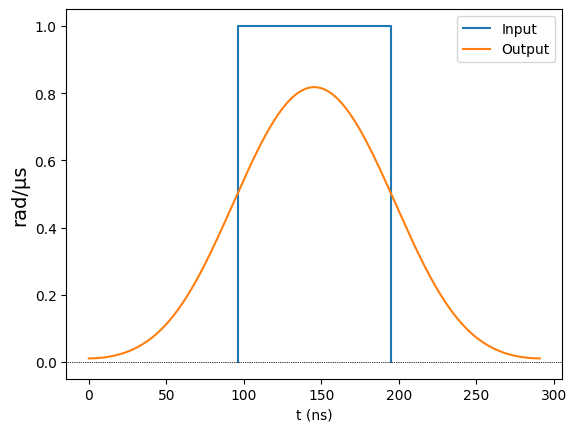

In [5]:
from pulser.waveforms import ConstantWaveform

constant_wf = ConstantWaveform(duration=100, value=1)
constant_wf.draw(output_channel=rydberg_ch)

We observe two things:
    
   1. The output is streched when compared with the input. This is always the case, and we refer to the time it takes the output to ramp up as the `rise time`. 
   2. The output does not have enough time to reach the maximum value set in the input. This happens only when the input pulse is too short.

If we make the pulse long enough, we will see that it will still be extended on both sides by the rise time, but now it reaches the maximum value:

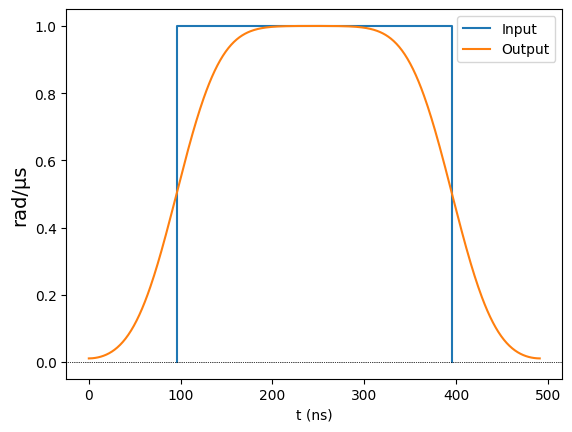

In [6]:
constant_wf2 = ConstantWaveform(duration=300, value=1)
constant_wf2.draw(output_channel=rydberg_ch)

Note also that all inputs are modulated, but the effect is most pronounced in square pulses. If we take, for example, a `BlackmanWaveform` of similar duration, we see the difference between input and output is more subtle (on the other hand, the output never gets a chance to reach the maximum value because the input is not held at the maximum value).

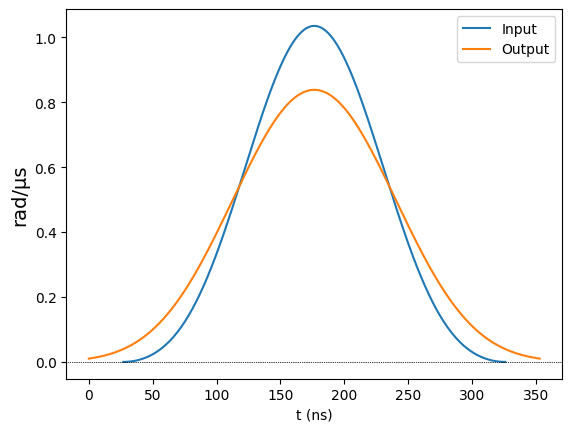

In [7]:
from pulser.waveforms import BlackmanWaveform

blackman_wf = BlackmanWaveform(300, 0.13)
blackman_wf.draw(output_channel=rydberg_ch)

### Influence in a Sequence

When creating a sequence on a device whose channels have a finite modulation bandwitdh, its effects are manifested in multiple ways. Let us start by creating such a device and making a simple pulse sequence with it.

In [8]:
raman_ch = Raman.Local(
    max_abs_detuning=0,
    max_amp=20 * 2 * np.pi,
    fixed_retarget_t=50,
    mod_bandwidth=4,
)

test_device = VirtualDevice(
    name="test_device",
    dimensions=2,
    rydberg_level=60,
    channel_objects=(rydberg_ch, raman_ch),
)

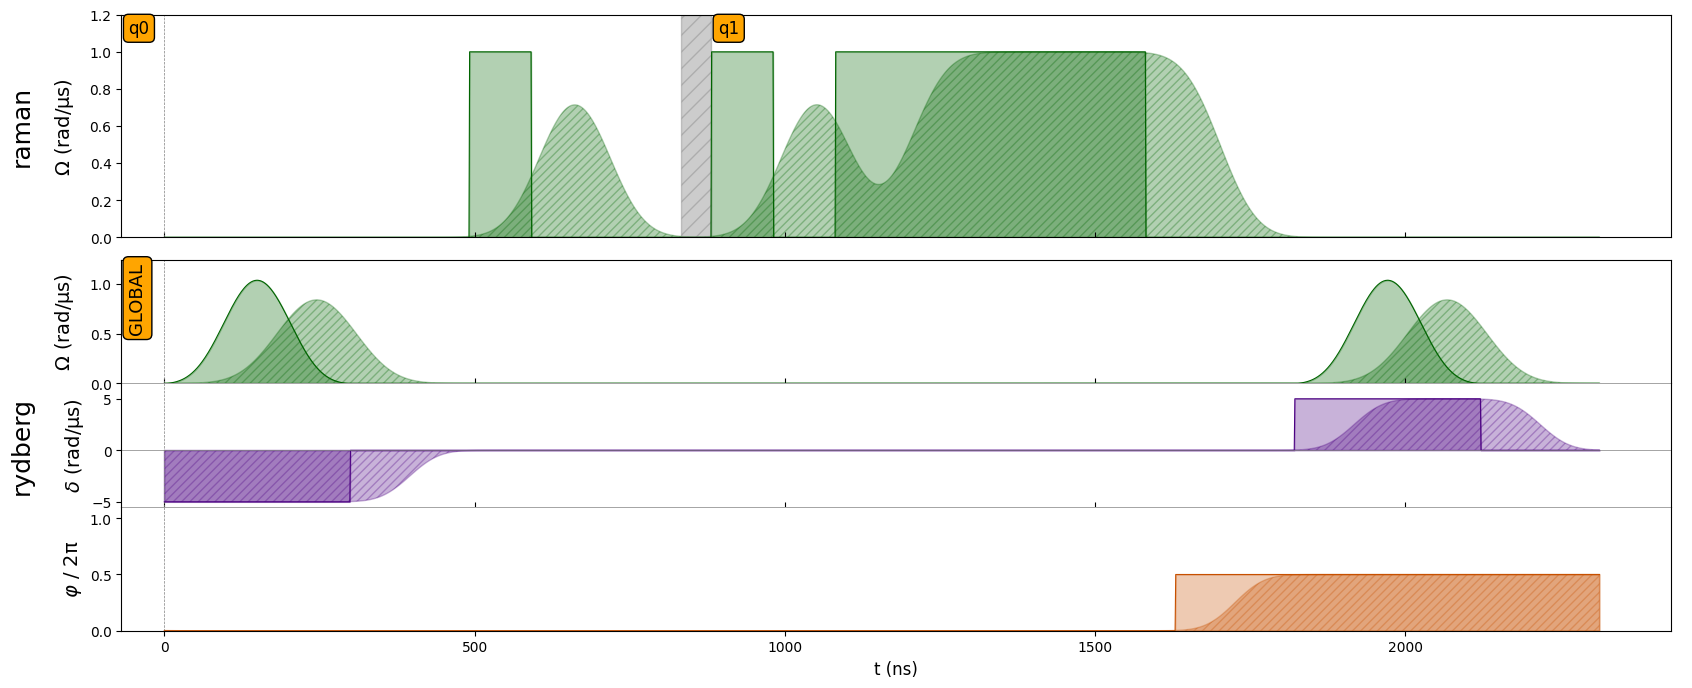

In [9]:
seq = Sequence(Register.square(2, prefix="q"), test_device)

seq.declare_channel("raman", "raman_local", initial_target="q0")
seq.declare_channel("rydberg", "rydberg_global")

seq.add(Pulse.ConstantDetuning(blackman_wf, -5, 0), "rydberg")

short_pulse = Pulse.ConstantPulse(100, 1, 0, 0)
seq.add(short_pulse, "raman")
seq.target("q1", "raman")
seq.add(short_pulse, "raman")
seq.delay(100, "raman")
long_pulse = Pulse.ConstantPulse(500, 1, 0, 0)
seq.add(long_pulse, "raman")

seq.add(Pulse.ConstantDetuning(blackman_wf, 5, np.pi), "rydberg")

seq.draw(draw_phase_curve=True)

By default, `Sequence.draw()` will display both the programmed input and the modulated output. In this way, one can compare how the output will change with respect to the intended input.

From looking at the output, there are multiple things to note:

1. Not only the amplitude but also the detuning and phase are modulated, all with the same modulation bandwidth.
2. Alignment between channels takes into account the extended duration of the pulses in the other channels. Note, for instance, how the last pulse on the `rydberg` channel starts only after the output of the `raman` channel goes to zero.
3. Similarly, changing the target in a local channel will also wait for the output to ramp down before starting the retargeting.
4. For consecutive pulses in the same channel, there is no automatically imposed delay between them to allow one pulse to finish before the next one starts. As such, whenever the interval between two pulses is too short, they will be "merged" together, as is illustrated in the `raman` channel.

### Usage in Simulation

In order to get the most realistic results when simulating a sequence, it may be valuable to use the expected output rather than the programmed input. To do so, one can simply initialize the `QutipEmulator` class with `with_modulation=True`.
Below, we simulate the sequence with and without modulation to assess the effect it has on the overlap between the resulting final states.

In [10]:
from pulser_simulation import QutipEmulator

sim_in = QutipEmulator.from_sequence(seq)
sim_out = QutipEmulator.from_sequence(seq, with_modulation=True)

input_final_state = sim_in.run().get_final_state()
output_final_state = sim_out.run().get_final_state()

print("Final state overlap:", input_final_state.overlap(output_final_state))

Final state overlap: (0.9999403734666137-3.868796064278209e-06j)


## EOM Mode Operation

The modulation bandwidth of a channel can impose significant limitations on how a pulse sequence is programmed. Perhaps most importantly, it can force the user to program longer pulses than would otherwise be required, resulting in longer sequences and consequently noisier results.

To overcome these limitations, a channel can be equipped with an EOM that allows the execution of square pulses with a higher modulation bandwidth. For now, EOM mode operation is reserved for `Rydberg` channels and works under very specific conditions:

   1. EOM mode must be explicitly enabled (`Sequence.enable_eom_mode()`) and disabled (`Sequence.disable_eom_mode()`).
   2. A buffering time is automatically added before the EOM mode is enabled and after it is disabled, as it needs to be isolated from regular channel operation. During the starting buffer, the detuning goes to the value it will assume between EOM pulses (_i.e._ during delays).
   3. When enabling the EOM mode, one must choose the amplitude and detuning value that all square pulses will have. These values will also determine a set of options for the detuning during delays, out of which the best one is chosen. When this detuning value is not zero, the phase of each qubit's state will drift during delays. If desired, this phase drift can be corrected through the `correct_phase_drift` option, which will adjust the phase of subsequent pulses accordingly. 
   4. While in EOM mode, one can only add delays or pulses of variable duration (through `Sequence.add_eom_pulse()`) – changing the phase between pulses is also allowed, but the necessary buffer time for a phase jump will still be enforced.

Let us showcase these features with the `AnalogDevice` device, which features an EOM on its `rydberg_global` channel.

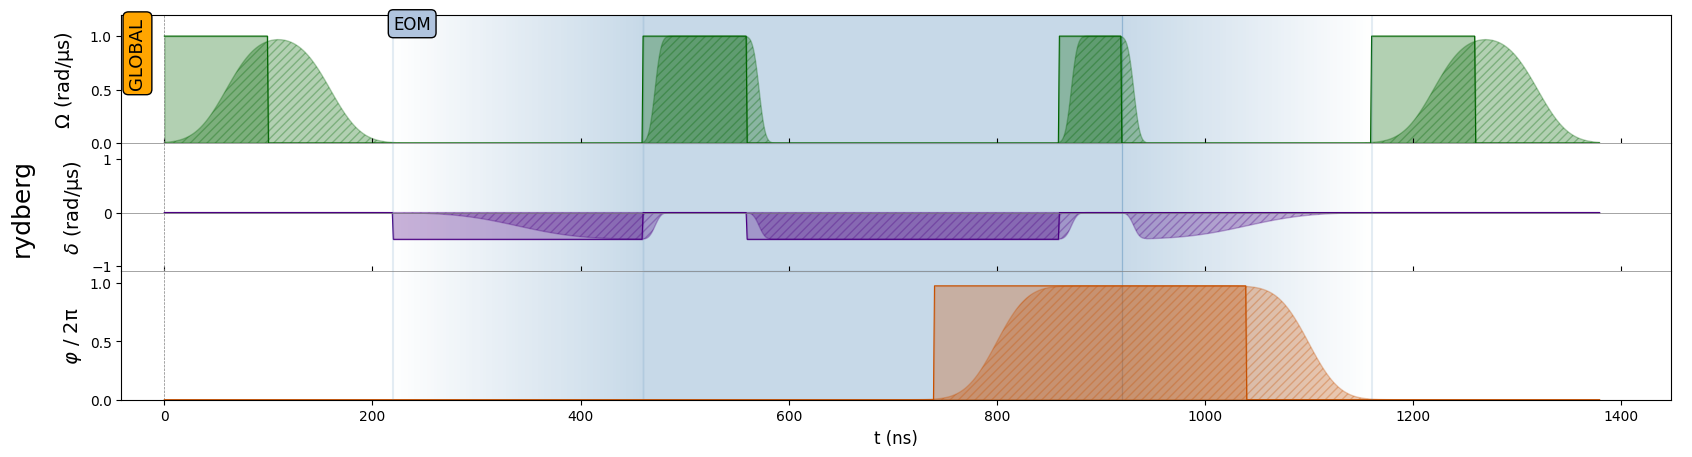

In [11]:
from pulser.devices import AnalogDevice

seq = Sequence(Register.square(2, spacing=6), AnalogDevice)
seq.declare_channel("rydberg", "rydberg_global")

seq.add(Pulse.ConstantPulse(100, 1, 0, 0), "rydberg")
seq.enable_eom_mode("rydberg", amp_on=1.0, detuning_on=0.0)
seq.add_eom_pulse("rydberg", duration=100, phase=0.0)
seq.delay(300, "rydberg")
seq.add_eom_pulse("rydberg", duration=60, phase=0.0, correct_phase_drift=True)
seq.disable_eom_mode("rydberg")
seq.add(Pulse.ConstantPulse(100, 1, 0, 0), "rydberg")

seq.draw(draw_phase_curve=True)

In [12]:
print(seq)

Channel: rydberg
t: 0 | Initial targets: 0, 1, 2, 3 | Phase Reference: 0.0 
t: 0->100 | Pulse(Amp=1 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: 0, 1, 2, 3
t: 100->220 | Delay 
t: 220->460 | Detuned Delay | Detuning: -0.5 rad/µs
t: 460->560 | Pulse(Amp=1 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: 0, 1, 2, 3
t: 560->860 | Detuned Delay | Detuning: -0.5 rad/µs
t: 860->920 | Pulse(Amp=1 rad/µs, Detuning=0 rad/µs, Phase=6.13) | Targets: 0, 1, 2, 3
t: 920->1160 | Delay 
t: 1160->1260 | Pulse(Amp=1 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: 0, 1, 2, 3




As expected, inside the isolated EOM mode block in the middle we see that the pulses are much sharper, but we can only do square pulses with a fixed amplitude and there is some non-zero detuning in between them. 

We also observe how the phase of the second EOM pulse changes to correct for the phase drift during the detuned delay (because we set `correct_phase_drift=True`).